### Exploratory data analysis: NTS, Census commuting flows and Census travel data



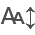

In [1]:
import os

import geopandas as gpd
from itables import init_notebook_mode
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import popgetter
from shapely import wkt

from acbm.config import load_and_setup_config
from acbm.utils import households_with_common_travel_days

init_notebook_mode(all_interactive=True, connected=False)

cfg = pl.Config()
cfg = cfg.set_tbl_rows(80)

In [2]:
# Set dir as repo root
os.chdir("../")

# Example config
config = load_and_setup_config("config/2025-01-20_leeds_msoa_new_regions_03.toml")

# Load NTS
nts_hh: pl.DataFrame = pl.DataFrame(
    pd.read_csv(config.nts_households_filepath, sep="\t")
)
nts_ind: pl.DataFrame = pl.DataFrame(
    pd.read_csv(config.nts_individuals_filepath, sep="\t")
)
nts_trips: pl.DataFrame = pl.DataFrame(pd.read_csv(config.nts_trips_filepath, sep="\t"))

In [3]:
def get_psu(config):
    psu = pl.DataFrame(pd.read_csv(config.psu_filepath, sep="\t"))

    # PSUStatsReg_B01ID but does not have values for 2021 and 2022
    region_dict = {
        -10.0: "DEAD",
        -9.0: "DNA",
        -8.0: "NA",
        1.0: "Northern, Metropolitan",
        2.0: "Northern, Non-metropolitan",
        3.0: "Yorkshire / Humberside, Metropolitan",
        4.0: "Yorkshire / Humberside, Non-metropolitan",
        5.0: "East Midlands",
        6.0: "East Anglia",
        7.0: "South East (excluding London Boroughs)",
        8.0: "London Boroughs",
        9.0: "South West",
        10.0: "West Midlands, Metropolitan",
        11.0: "West Midlands, Non-metropolitan",
        12.0: "North West, Metropolitan",
        13.0: "North West, Non-metropolitan",
        14.0: "Wales",
        15.0: "Scotland",
    }

    # In the PSU table, create a column with the region names
    # psu["region_name"] = psu["PSUGOR_B02ID"].map(region_dict)
    return psu.with_columns(
        pl.col("PSUStatsReg_B01ID").replace(region_dict).alias("region_name")
    )


def transform_nts_trips(nts_trips: pl.DataFrame):
    nts_trips = nts_trips.rename(
        {  # rename data
            "JourSeq": "seq",
            "TripOrigGOR_B02ID": "ozone",
            "TripDestGOR_B02ID": "dzone",
            "TripPurpFrom_B01ID": "oact",
            "TripPurpTo_B01ID": "dact",
            "MainMode_B04ID": "mode",
            "TripStart": "tst",
            "TripEnd": "tet",
        }
    )
    mode_mapping = {
        1: "walk",
        2: "bike",
        3: "car",  #'Car/van driver'
        4: "car_passenger",  #'Car/van passenger'
        5: "motorcycle",  #'Motorcycle',
        6: "car",  #'Other private transport',
        7: "pt",  # Bus in London',
        8: "pt",  #'Other local bus',
        9: "pt",  #'Non-local bus',
        10: "pt",  #'London Underground',
        11: "pt",  #'Surface Rail',
        12: "taxi",  #'Taxi/minicab',
        13: "pt",  #'Other public transport',
        -10: "DEAD",
        -8: "NA",
    }

    purp_mapping = {
        1: "work",
        2: "work",  #'In course of work',
        3: "education",
        4: "shop",  #'Food shopping',
        5: "shop",  #'Non food shopping',
        6: "medical",  #'Personal business medical',
        7: "other",  #'Personal business eat/drink',
        8: "other",  #'Personal business other',
        9: "other",  #'Eat/drink with friends',
        10: "visit",  #'Visit friends',
        11: "other",  #'Other social',
        12: "other",  #'Entertain/ public activity',
        13: "other",  #'Sport: participate',
        14: "home",  #'Holiday: base',
        15: "other",  #'Day trip/just walk',
        16: "other",  #'Other non-escort',
        17: "escort",  #'Escort home',
        18: "escort",  #'Escort work',
        19: "escort",  #'Escort in course of work',
        20: "escort",  #'Escort education',
        21: "escort",  #'Escort shopping/personal business',
        22: "escort",  #'Other escort',
        23: "home",  #'Home',
        -10: "DEAD",
        -8: "NA",
    }
    return nts_trips.with_columns(
        [
            pl.col("mode").replace(mode_mapping),
            pl.col("oact").replace(purp_mapping),
            pl.col("dact").replace(purp_mapping),
        ]
    )

In [4]:
# Get PSU
psu = get_psu(config)

# Transform NTS trips
nts_trips = transform_nts_trips(nts_trips)

#### Does the `WkPlace_B01ID` variable provide a good indicator of the number in NTS working from home


In [5]:
# Value = 1.0 Label = Same place
# Value = 2.0 Label = Same place on at least 2 consecutive days
# Value = 3.0 Label = Different places
# Value = 4.0 Label = Home/same building as home
# Value = -10.0 Label = DEAD
# Value = -9.0 Label = DNA
# Value = -8.0 Label = NA
ids_with_work_trips = (
    nts_trips.filter(pl.col("dact").eq("work"))
    .unique("IndividualID")
    .get_column("IndividualID")
    .to_list()
)

workplace_var = "WkPlace_B01ID"
workplace_var_recoded = "work_location"
nts_ind = nts_ind.with_columns(
    pl.col(workplace_var)
    .replace(
        {
            1: "Same place",
            2: "Same place on at least 2 consecutive days",
            3: "Different places",
            4: "Home/same building as home",
            -10: "Dead",
            -9: "DNA",
            -8: "NA",
        }
    )
    .alias(workplace_var_recoded)
)
(
    nts_ind.filter(
        pl.col("SurveyYear").is_in([2021, 2022])
        # & pl.col("IndividualID").is_in(ids_with_work_trips)
    )
    .get_column(workplace_var_recoded)
    .value_counts()
    .sort("count")
    .with_columns((pl.col("count") / pl.col("count").sum()).alias("prop (2021, 2022)"))
    .rename({"count": "count (2021, 2022)"})
    .join(
        nts_ind.filter(~pl.col("SurveyYear").is_in([2021, 2022]))
        .get_column(workplace_var_recoded)
        .value_counts()
        .sort("count")
        .with_columns(
            (pl.col("count") / pl.col("count").sum()).alias("prop (not 2021, 2022)")
        )
        .rename({"count": "count (not 2021, 2022)"}),
        on="work_location",
        how="full",
        coalesce=True,
    )
)

shape: (7, 5)
┌──────────────────────────┬──────────────┬───────────────────┬──────────────────┬─────────────────┐
│ work_location            ┆ count (2021, ┆ prop (2021, 2022) ┆ count (not 2021, ┆ prop (not 2021, │
│ ---                      ┆ 2022)        ┆ ---               ┆ 2022)            ┆ 2022)           │
│ str                      ┆ ---          ┆ f64               ┆ ---              ┆ ---             │
│                          ┆ u32          ┆                   ┆ u32              ┆ f64             │
╞══════════════════════════╪══════════════╪═══════════════════╪══════════════════╪═════════════════╡
│ NA                       ┆ 13           ┆ 0.000632          ┆ 549              ┆ 0.00151         │
│ Same place on at least 2 ┆ 240          ┆ 0.011663          ┆ 10989            ┆ 0.03022         │
│ conse…                   ┆              ┆                   ┆                  ┆                 │
│ Different places         ┆ 846          ┆ 0.041112          ┆ 25853            ┆ 0.071095        │
│ Home/same building as    ┆ 1182         ┆ 0.05744           ┆ 7774             ┆ 0.021378        │
│ home                     ┆              ┆                   ┆                  ┆                 │
│ Same place               ┆ 2912         ┆ 0.14151           ┆ 122864           ┆ 0.337874        │
│ DNA                      ┆ 5743         ┆ 0.279084          ┆ 195610           ┆ 0.537924        │
│ Dead                     ┆ 9642         ┆ 0.468559          ┆ null             ┆ null            │
└──────────────────────────┴──────────────┴───────────────────┴──────────────────┴─────────────────┘

In [6]:
df = (
    nts_ind.filter(
        pl.col("SurveyYear").is_in([2021, 2022])
        & pl.col("IndividualID").is_in(ids_with_work_trips)
    )
    .get_column(workplace_var_recoded)
    .value_counts()
    .sort("count")
    .with_columns((pl.col("count") / pl.col("count").sum()).alias("prop (2021, 2022)"))
    .rename({"count": "count (2021, 2022)"})
)
df

shape: (6, 3)
┌─────────────────────────────────┬────────────────────┬───────────────────┐
│ work_location                   ┆ count (2021, 2022) ┆ prop (2021, 2022) │
│ ---                             ┆ ---                ┆ ---               │
│ str                             ┆ u32                ┆ f64               │
╞═════════════════════════════════╪════════════════════╪═══════════════════╡
│ DNA                             ┆ 63                 ┆ 0.011417          │
│ Same place on at least 2 conse… ┆ 160                ┆ 0.028996          │
│ Home/same building as home      ┆ 206                ┆ 0.037332          │
│ Different places                ┆ 442                ┆ 0.080101          │
│ Same place                      ┆ 1930               ┆ 0.349764          │
│ Dead                            ┆ 2717               ┆ 0.492389          │
└─────────────────────────────────┴────────────────────┴───────────────────┘

##### How does the number of people travelling by each mode vary across regions


In [7]:
nts_trips.join(psu.select(["PSUID", "region_name"]), on="PSUID").filter(
    pl.col("dact").eq("work") & pl.col("SurveyYear").is_in([2021, 2022])
).group_by(["region_name", "mode"]).len().pivot(
    columns=["mode"], index=["region_name"], values="len"
)

shape: (13, 8)
┌─────────────────────────────────┬──────┬──────┬──────┬────────────┬───────────────┬──────┬──────┐
│ region_name                     ┆ bike ┆ car  ┆ walk ┆ motorcycle ┆ car_passenger ┆ pt   ┆ taxi │
│ ---                             ┆ ---  ┆ ---  ┆ ---  ┆ ---        ┆ ---           ┆ ---  ┆ ---  │
│ str                             ┆ u32  ┆ u32  ┆ u32  ┆ u32        ┆ u32           ┆ u32  ┆ u32  │
╞═════════════════════════════════╪══════╪══════╪══════╪════════════╪═══════════════╪══════╪══════╡
│ West Midlands, Non-metropolita… ┆ 31   ┆ 948  ┆ 46   ┆ 2          ┆ 92            ┆ 40   ┆ 6    │
│ North West, Metropolitan        ┆ 58   ┆ 1226 ┆ 113  ┆ 5          ┆ 109           ┆ 187  ┆ 26   │
│ East Midlands                   ┆ 31   ┆ 1203 ┆ 68   ┆ 17         ┆ 87            ┆ 115  ┆ 9    │
│ Northern, Metropolitan          ┆ 2    ┆ 446  ┆ 41   ┆ 9          ┆ 59            ┆ 102  ┆ 12   │
│ Yorkshire / Humberside, Non-me… ┆ 25   ┆ 541  ┆ 38   ┆ null       ┆ 40            ┆ 14   ┆ 1    │
│ North West, Non-metropolitan    ┆ 9    ┆ 774  ┆ 38   ┆ null       ┆ 50            ┆ 38   ┆ 4    │
│ South East (excluding London B… ┆ 204  ┆ 3817 ┆ 336  ┆ 39         ┆ 288           ┆ 541  ┆ 27   │
│ West Midlands, Metropolitan     ┆ 25   ┆ 480  ┆ 34   ┆ 1          ┆ 65            ┆ 78   ┆ 8    │
│ South West                      ┆ 92   ┆ 1877 ┆ 146  ┆ 27         ┆ 175           ┆ 109  ┆ 6    │
│ Northern, Non-metropolitan      ┆ 8    ┆ 713  ┆ 51   ┆ null       ┆ 81            ┆ 39   ┆ 11   │
│ East Anglia                     ┆ 23   ┆ 649  ┆ 62   ┆ 9          ┆ 93            ┆ 29   ┆ 9    │
│ Yorkshire / Humberside, Metrop… ┆ 12   ┆ 846  ┆ 90   ┆ 1          ┆ 140           ┆ 117  ┆ 4    │
│ London Boroughs                 ┆ 193  ┆ 873  ┆ 143  ┆ 30         ┆ 139           ┆ 1199 ┆ 34   │
└─────────────────────────────────┴──────┴──────┴──────┴────────────┴───────────────┴──────┴──────┘

In [8]:
# Explore work-related variables in NTS
workplace_var = "WkPlace_B01ID"
nts_ind.get_column(workplace_var).value_counts().sort("count")

# TODO: explore matching with SPC pwkstat here

shape: (7, 2)
┌───────────────┬────────┐
│ WkPlace_B01ID ┆ count  │
│ ---           ┆ ---    │
│ i64           ┆ u32    │
╞═══════════════╪════════╡
│ -8            ┆ 562    │
│ 4             ┆ 8956   │
│ -10           ┆ 9642   │
│ 2             ┆ 11229  │
│ 3             ┆ 26699  │
│ 1             ┆ 125776 │
│ -9            ┆ 201353 │
└───────────────┴────────┘

In [9]:
# Addtionally can call this function to susbet the dataframes
def get_nts_subset(nts_hh, nts_ind, nts_trips):
    # Get HIDs with common travel days
    hids = households_with_common_travel_days(
        nts_trips.to_pandas(), config.parameters.nts_days_of_week
    )
    # Subset individuals and households given filtering of trips
    nts_trips = nts_trips.filter(
        pl.col("HouseholdID").is_in(hids)
        & pl.col("TravDay").is_in(config.parameters.nts_days_of_week)
        & pl.col("SurveyYear").is_in(config.parameters.nts_years)
    )
    nts_individuals = nts_ind.filter(pl.col("HouseholdID").is_in(hids))
    nts_hh = nts_hh.filter(pl.col("HouseholdID").is_in(hids))
    return nts_hh, nts_individuals, nts_trips

#### How does the distribution of travel times vary at the region level?


In [10]:
# get times grouped by region
col = "TripTotalTime"
# col = "TripDisIncSW"

mode = "car"
# mode = "pt"

by_region = (
    nts_trips.join(psu.select(["PSUID", "region_name"]), on="PSUID")
    .filter(pl.col("mode").eq(mode) & pl.col("dact").eq("work"))
    .group_by("region_name")
    .agg(
        [
            pl.col(col).quantile(0.25).alias("25th"),
            pl.col(col).quantile(0.5).alias("50th"),
            pl.col(col).quantile(0.75).alias("75th"),
            pl.col(col).mean().alias("mean").round(2),
            pl.col(col).std().alias("std").round(2),
        ]
    )
).sort("region_name")

by_region

shape: (15, 6)
┌─────────────────────────────────┬──────┬──────┬──────┬───────┬───────┐
│ region_name                     ┆ 25th ┆ 50th ┆ 75th ┆ mean  ┆ std   │
│ ---                             ┆ ---  ┆ ---  ┆ ---  ┆ ---   ┆ ---   │
│ str                             ┆ f64  ┆ f64  ┆ f64  ┆ f64   ┆ f64   │
╞═════════════════════════════════╪══════╪══════╪══════╪═══════╪═══════╡
│ East Anglia                     ┆ 10.0 ┆ 20.0 ┆ 30.0 ┆ 26.01 ┆ 27.98 │
│ East Midlands                   ┆ 10.0 ┆ 20.0 ┆ 30.0 ┆ 27.13 ┆ 30.18 │
│ London Boroughs                 ┆ 15.0 ┆ 25.0 ┆ 40.0 ┆ 31.59 ┆ 27.18 │
│ North West, Metropolitan        ┆ 14.0 ┆ 20.0 ┆ 30.0 ┆ 27.04 ┆ 26.9  │
│ North West, Non-metropolitan    ┆ 10.0 ┆ 20.0 ┆ 30.0 ┆ 25.74 ┆ 27.56 │
│ Northern, Metropolitan          ┆ 12.0 ┆ 20.0 ┆ 30.0 ┆ 24.35 ┆ 28.57 │
│ Northern, Non-metropolitan      ┆ 10.0 ┆ 20.0 ┆ 30.0 ┆ 24.37 ┆ 26.91 │
│ Scotland                        ┆ 10.0 ┆ 20.0 ┆ 30.0 ┆ 25.99 ┆ 33.81 │
│ South East (excluding London B… ┆ 10.0 ┆ 20.0 ┆ 35.0 ┆ 28.13 ┆ 28.71 │
│ South West                      ┆ 10.0 ┆ 20.0 ┆ 30.0 ┆ 25.92 ┆ 29.58 │
│ Wales                           ┆ 10.0 ┆ 20.0 ┆ 30.0 ┆ 25.16 ┆ 28.75 │
│ West Midlands, Metropolitan     ┆ 14.0 ┆ 20.0 ┆ 30.0 ┆ 26.27 ┆ 24.77 │
│ West Midlands, Non-metropolita… ┆ 10.0 ┆ 20.0 ┆ 30.0 ┆ 26.24 ┆ 28.67 │
│ Yorkshire / Humberside, Metrop… ┆ 12.0 ┆ 20.0 ┆ 30.0 ┆ 26.1  ┆ 26.58 │
│ Yorkshire / Humberside, Non-me… ┆ 10.0 ┆ 20.0 ┆ 30.0 ┆ 25.23 ┆ 29.73 │
└─────────────────────────────────┴──────┴──────┴──────┴───────┴───────┘

#### How does the proportion travelling to work change over time in NTS?


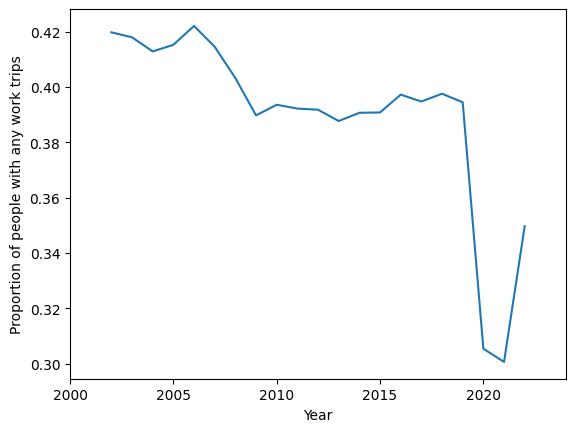

In [11]:
df = (
    nts_trips.group_by(["SurveyYear", "IndividualID"])
    .agg((pl.lit("work").is_in(pl.col("dact")) * 1).alias("any_work_activity"))
    .group_by("SurveyYear")
    .mean()
    .sort("SurveyYear")
    .select(["SurveyYear", "any_work_activity"])
)

plt.plot(df.select("SurveyYear"), df.select("any_work_activity"))
plt.gca().set(
    xlim=(2000, 2024), ylabel="Proportion of people with any work trips", xlabel="Year"
)
plt.show()


### What is the spatial distribution of distance travelled to work

Here we explore the spatial distribution by distance travelled to work in the study area.


In [12]:
# Explore distance to work in study region
def get_census_data(config, include_geometry=True, use_cache=True):
    filepath = config.external_path / "TS058-2021-msoa-leeds.csv"
    if os.path.isfile(filepath) and use_cache:
        return pd.read_csv(filepath)

    # Search and download data with search params
    search_params = {
        # Short metric IDs for reference
        # "metric_id": [
        #     {"id": "2619a2b91e"}, {"id": "512663ccc3"}, {"id": "dc435eb8d0"}, {"id": "d92aca6569"},
        #     {"id": "cfdb70149d"}, {"id": "af7bebda58"}, {"id": "b660dd5386"}, {"id": "efa45af2da"},
        #     {"id": "71154fc462"}, {"id": "55426cb07f"},
        # ],
        "metric_id": [],
        "text": [
            {
                "text": "Distance travelled to work:",
                "config": {"match_type": "Regex", "case_sensitivity": "Insensitive"},
                "context": ["HumanReadableName"],
            }
        ],
        "geometry_level": {
            "value": "msoa",
            "config": {"match_type": "Exact", "case_sensitivity": "Insensitive"},
        },
        "year_range": [{"Between": [2021, 2021]}],
        "country": {
            "value": "England and Wales",
            "config": {"match_type": "Regex", "case_sensitivity": "Insensitive"},
        },
        # Currently popgetter python bindings require specification in CRS of data (27700 for England and Wales)
        # "region_spec": [{"BoundingBox": [390955, 403436, 474332, 460372]}],
        # "region_spec": [{"include_geometry": include_geometry}]
    }
    df = popgetter.download(search_params).to_pandas()
    df.to_csv(filepath, index=None)
    return df


def get_geo_df_and_study_area(config):
    # Read TS058 census table at MSOA level
    df = get_census_data(config)
    df = gpd.GeoDataFrame(df)
    df["geometry"] = df["geometry"].map(lambda geo: wkt.loads(geo))
    return df.set_geometry("geometry").set_crs(
        27700
    ), config.get_study_area_boundaries()


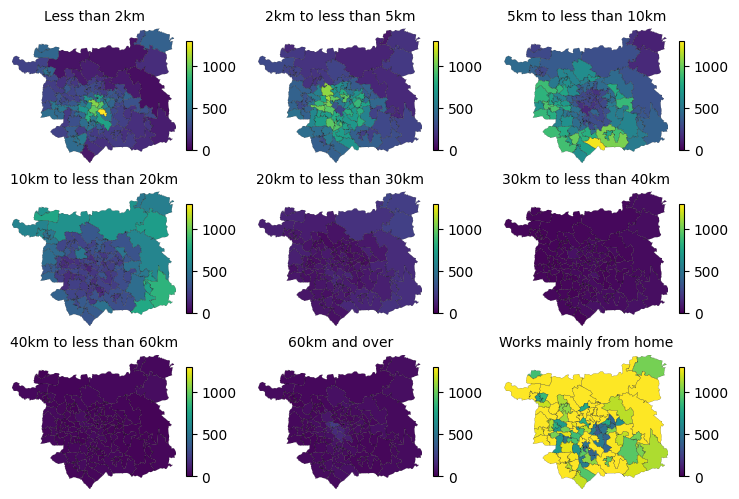

In [13]:
# Get census data and study area
gdf, study_area = get_geo_df_and_study_area(config)

# Subset to study area
gdf = gdf[gdf["GEO_ID"].isin(study_area["MSOA21CD"])]

# Plot
cols = gdf.columns[3:-1]
nrows, ncols = 3, 3
fig, axs = plt.subplots(nrows, ncols, figsize=(9, 6))
for idx, column in enumerate(cols):
    row = idx // ncols
    col = idx % ncols
    ax = axs[row, col]
    legend_kwds = {"shrink": 0.8}
    gdf.plot(
        ax=ax,
        column=column,
        legend=True,
        cmap="viridis",
        legend_kwds=legend_kwds,
        vmin=0,
        vmax=gdf[cols].max().values[0],
    )
    ax.axis("off")
    minx, miny, maxx, maxy = gdf.total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    study_area.plot(facecolor="none", edgecolor="black", lw=0.1, ax=ax)
    ax.set_title(column.split("Distance travelled to work: ")[1], size="medium")
plt.show()

In [14]:
df: pl.DataFrame = popgetter.download_data_request(
    {
        "region": [],
        "metrics": [
            {"MetricText": "number of cars"},
        ],
        "years": ["2021"],
        "geometry": {"geometry_level": "msoa", "include_geoms": False},
        "region_spec": [],
    }
)
gdf_cars = (
    gpd.GeoDataFrame(
        df.filter(pl.col("GEO_ID").is_in(study_area["MSOA21CD"])).to_pandas()
    )
    .merge(gdf[["GEO_ID", "geometry"]])
    .set_geometry("geometry")
)

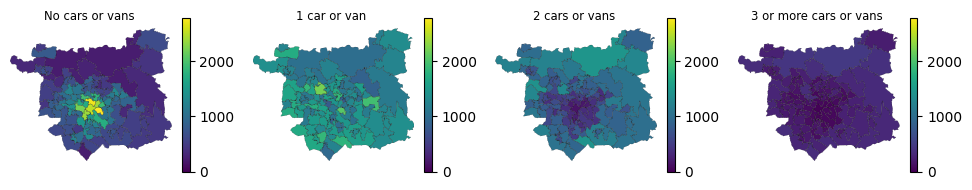

In [15]:
# Plot
column_names = gdf_cars.columns[2:6]
nrows, ncols = 1, 4
fig, axs = plt.subplots(nrows, ncols, figsize=(12, 4), squeeze=False)
for idx, column_name in enumerate(column_names):
    row = idx // ncols
    col = idx % ncols
    ax = axs[row, col]
    legend_kwds = {"shrink": 0.5}
    gdf_cars.plot(
        ax=ax,
        column=column_name,
        legend=True,
        cmap="viridis",
        legend_kwds=legend_kwds,
        vmin=0,
        vmax=gdf_cars[column_names].max().values[0],
    )
    ax.axis("off")
    minx, miny, maxx, maxy = gdf.total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    study_area.plot(facecolor="none", edgecolor="black", lw=0.1, ax=ax)
    ax.set_title(
        column_name.split("Number of cars or vans: ")[1].split("in household")[0],
        size="small",
    )
plt.show()

#### What propotion of those employed mainly working from home (2021 census)


In [16]:
# Get census data for all MSOAs
df: pl.DataFrame = popgetter.download_data_request(
    {
        "region": [],
        "metrics": [
            {"MetricText": "Distance travelled"},
        ],
        "years": ["2021"],
        "geometry": {"geometry_level": "msoa", "include_geoms": False},
        "region_spec": [],
    }
)


In [17]:
df.columns

['GEO_ID',
 'Distance travelled to work: Total: All usual residents aged 16 years and over in employment the week before the census',
 'Distance travelled to work: Less than 2km',
 'Distance travelled to work: 2km to less than 5km',
 'Distance travelled to work: 5km to less than 10km',
 'Distance travelled to work: 10km to less than 20km',
 'Distance travelled to work: 20km to less than 30km',
 'Distance travelled to work: 30km to less than 40km',
 'Distance travelled to work: 40km to less than 60km',
 'Distance travelled to work: 60km and over',
 'Distance travelled to work: Works mainly from home',
 'Distance travelled to work: Works mainly at an offshore installation, in no fixed place, or outside the UK']

In [18]:
# Transform and plot histogram
plot = df.select(pl.col("GEO_ID"), pl.nth(range(2, 10))).melt(id_vars="GEO_ID").group_by(
    "GEO_ID"
).agg(pl.col("value").sum().alias("Travel to work")).join(
    df.select(
        [
            pl.col("GEO_ID"),
            pl.nth(10).alias("WFH"),
            pl.nth(1).alias("Total employed"),
        ]
    ),
    on="GEO_ID",
).select([(pl.col("WFH") / pl.col("Total employed")).alias("Proportion WFH")]).plot(
    kind="hist",
    xlim=(0, 1),
    title="Proportion employed mainly working from home by MSOA",
)


In [19]:
from IPython.display import display

display(plot)


:Histogram   [Proportion WFH]   (Count)

['Middle Layer Super Output Areas Code', 'Middle Layer Super Output Areas', 'Distance travelled to work (11 categories) Code', 'Distance travelled to work (11 categories)', 'Observation']


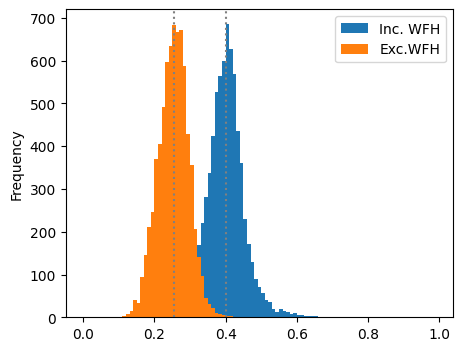

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl

# https://statistics.ukdataservice.ac.uk/dataset/england-and-wales-census-2021-ts058-distance-travelled-to-work
# df = pl.read_excel("data/external/TS058-Distance-Travelled-To-Work-2021-ltla-ONS.xlsx")
df = pl.read_excel("data/external/TS058-Distance-Travelled-To-Work-2021-msoa-ONS.xlsx")
print(df.columns)
fig, ax = plt.subplots(1, 1, figsize=(5, 4), squeeze=True)

for label, values in [
    (
        "Inc. WFH",
        [
            "Works mainly at an offshore installation, in no fixed place, or outside the UK",
            "Does not apply",
        ],
    ),
    (
        "Exc.WFH",
        [
            "Works mainly at an offshore installation, in no fixed place, or outside the UK",
            "Does not apply",
            "Works mainly from home",
        ],
    ),
]:
    # area_col = "Lower Tier Local Authorities"
    area_col = "Middle Layer Super Output Areas"
    fraction_travel = (
        df.join(
            df.group_by([area_col]).agg(pl.col("Observation").sum().alias("sum")),
            on=[area_col],
            how="left",
            coalesce=True,
        )
        .select(
            [
                pl.col(area_col),
                pl.col("Distance travelled to work (11 categories)"),
                pl.col("Observation"),
                (pl.col("Observation") / pl.col("sum")).alias("frac"),
            ]
        )
        .filter(~pl.col("Distance travelled to work (11 categories)").is_in(values))
        .group_by(area_col)
        .agg(pl.col("frac").sum())
    )
    fraction_travel.get_column("frac").alias(label).to_pandas().plot(
        kind="hist", bins=np.arange(0, 1, 0.01), ax=ax
    )
    ax.axvline(
        fraction_travel.select("frac").median().to_numpy()[0, 0], c="grey", ls=":"
    )
plt.legend()
plt.show()
